### Описание проекта
**Цель проекта**: Изучить данные о пользователях, выявить причины убытков и найти решения для выхода компании в плюс.<br>
В нашем распоряжении три файла от компании Procrastinate Pro+, первый это лог сервера с информацией о посещениях сайта, второй с информацией о заказах и третий с информацией о расходах на рекламу.

Для достижения цели изучили:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов

В конце проекта сделаны выводы, представлены причины неэффективности привлечения пользователей и рекомендации для маркетинга.

### Загрузка данных и подготовка их к анализу

In [1]:
# Импортируем необходмые библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# Открываем все файлы
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
# Создадим функцию для первичной обработки данных
def first_analys(data):
    data.columns = [x.lower().replace(' ', '_') for x in data.columns]
    data.drop_duplicates()
    return data.info(), data.head()

In [4]:
first_analys(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


(None,
         user_id         region   device  channel        session_start  \
 0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
 1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
 2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
 3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
 4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   
 
            session_end  
 0  2019-05-01 02:45:01  
 1  2019-05-01 04:47:35  
 2  2019-05-01 15:32:08  
 3  2019-05-01 00:54:25  
 4  2019-05-01 03:57:40  )

In [5]:
first_analys(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


(None,
         user_id             event_dt  revenue
 0  188246423999  2019-05-01 23:09:52     4.99
 1  174361394180  2019-05-01 12:24:04     4.99
 2  529610067795  2019-05-01 11:34:04     4.99
 3  319939546352  2019-05-01 15:34:40     4.99
 4  366000285810  2019-05-01 13:59:51     4.99)

In [6]:
first_analys(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


(None,
            dt   channel  costs
 0  2019-05-01  FaceBoom  113.3
 1  2019-05-02  FaceBoom   78.1
 2  2019-05-03  FaceBoom   85.8
 3  2019-05-04  FaceBoom  136.4
 4  2019-05-05  FaceBoom  122.1)

In [7]:
# Приведем необходимые столбцы к типу datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
costs['dt'] = pd.to_datetime(costs['dt'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

Все данные обработаны для дальнейшего исследования, столбцы с датами переведены к типу datetime, изменены названия столбцов.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Зададим функции с некоторыми изменениями для нашего исследования (исключим из функции для расчета окупаемости рекламы органический канал привлечения и немного увеличим площадь под графики).

#### Функция для создания профилей пользователей  ####

In [8]:
# функция для создания профилей

def get_profiles(sessions, orders, costs):
    # находим параметры первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
                .groupby('user_id')
                .agg(
                    {
                        'session_start' : 'first',
                        'channel' : 'first',
                        'device' : 'first',
                        'region' : 'first'
                    }
                )
                .rename(columns={'session_start' : 'first_ts'})
                .reset_index()
               )
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак пользователей, совершивших покупку
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    costs['dt'] = pd.to_datetime(costs['dt']).dt.date
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

#### Функция для расчёта удержания #####

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для расчета конверсии ####

In [10]:
# Функция для расчета конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для расчёта LTV и ROI ####

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date and channel != "organic"')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### Функция для сглаживания фрейма ####

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функции для визуализации ####

In [13]:
def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(25, 20))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(25, 15))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(30, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [16]:
# получим профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [17]:
# Узнаем минимальную дату привлечения пользователей
min_dt = profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [18]:
# Узнаем максимальную дату привлечения
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

Полученные даты соответсвуют указанным в задании

Узнаем из каких стран приходит больше всего пользователей и где больше доля платящих пользователей. Сделаем тоже самое и для видов устройств и источников привлечения.

In [52]:
country_prof = profiles.groupby('region').agg({'payer':'mean'})
country_prof

payer
region                 
France         0.037994
Germany        0.041119
UK             0.039829
United States  0.069019

In [53]:
country_prof.columns = ['perc']

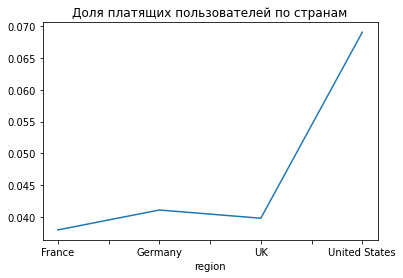

In [55]:
country_prof['perc'].plot()
plt.title('Доля платящих пользователей по странам')
plt.show()

В США больше всего привлеченных пользователей, там же доля платящих наибольшая почти 7%, в остальных странах процент меньше 5.

In [23]:
# Узнаем количество пользователей и процент платящих по устройствам пользователей.
device_prof = profiles.groupby('device').agg({'payer':'mean'})
device_prof

payer      
         count   sum
device              
Android  35032  2050
Mac      30042  1912
PC       30455  1537
iPhone   54479  3382

In [24]:
device_prof.columns = ['perc']

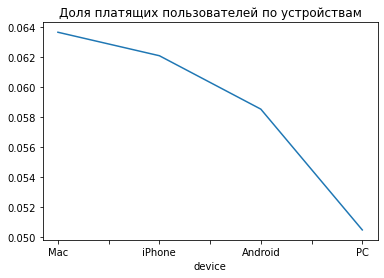

In [26]:
device_prof.sort_values(by='perc', ascending=False)['perc'].plot()
plt.title('Доля платящих пользователей по устройствам')
plt.show()

Больше всего пользователей используют iPhone, меньше всего Mac. Хотя доля платящих максимальная у Mac, наименьшая у пользователей РС. Можно сказать что пользователи ПО iOS платят чаще.

In [27]:
channel_prof = profiles.groupby('channel').agg({'payer':['count', 'sum']})
channel_prof

payer      
                    count   sum
channel                        
AdNonSense           3880   440
FaceBoom            29144  3557
LeapBob              8553   262
MediaTornado         4364   156
OppleCreativeMedia   8605   233
RocketSuperAds       4448   352
TipTop              19561  1878
WahooNetBanner       8553   453
YRabbit              4312   165
lambdaMediaAds       2149   225
organic             56439  1160

In [28]:
channel_prof.columns = ['count_payer', 'sum_payer']

In [29]:
channel_prof['perc'] = channel_prof['sum_payer'] / channel_prof['count_payer']
channel_prof.sort_values(by='perc', ascending=False)

count_payer  sum_payer      perc
channel                                             
FaceBoom                  29144       3557  0.122049
AdNonSense                 3880        440  0.113402
lambdaMediaAds             2149        225  0.104700
TipTop                    19561       1878  0.096007
RocketSuperAds             4448        352  0.079137
WahooNetBanner             8553        453  0.052964
YRabbit                    4312        165  0.038265
MediaTornado               4364        156  0.035747
LeapBob                    8553        262  0.030633
OppleCreativeMedia         8605        233  0.027077
organic                   56439       1160  0.020553

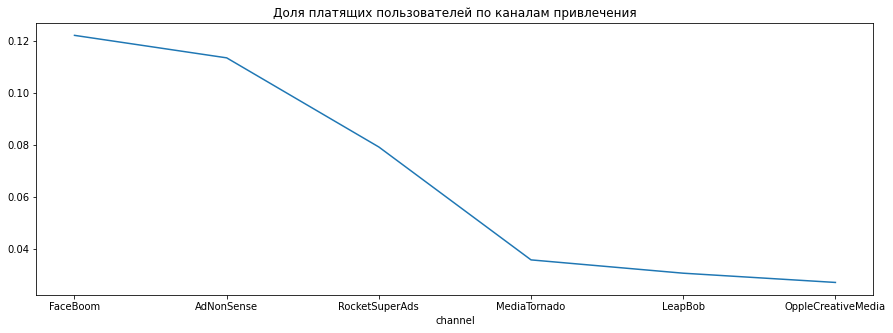

In [30]:
plt.figure(figsize=(15, 5))
channel_prof[:6].sort_values(by='perc', ascending=False)['perc'].plot()
plt.title('Доля платящих пользователей по каналам привлечения')
plt.show()

Больше пользователей приходят из органических каналов привлечений. Каналы, на которых размещается реклама, привлекающие больше пользователей это TipTop и FaceBoom. Доля платящих пользователей равная больше 10% приходит на такие каналы как FaceBoom, AdNonSense и lambdaMediaAds. 

По итогу можем сказать, что данные о привлечении доступны нам с 1 мая по 27 октября 2019 года. Мы создали профили пользователей и с их помощью определили, что из США приходят больше пользователей, там же доля платящих выше, чем в остальных регионах, примерно 7%. Устройства на плтаформе ios приносят больше платящих пользователей, хотя в общем количестве верхние позиции делят iPhone и Androi, а Mac на последнем месте. Такие каналы привлечение как FaceBoom, AdNonSense и lambdaMediaAds приведят больше 10% пользователей. LeapBob, OppleCreativeMedia и organic приносят меньше 3.5% платящих пользователей.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [31]:
# Посчитаем общую сумму затрат на маркетинг
costs['costs'].sum()

105497.30000000002

In [32]:
top_costs = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
top_costs

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

<Figure size 1080x360 with 0 Axes>

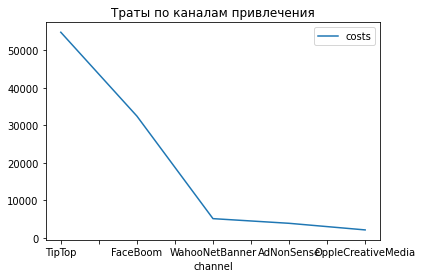

In [33]:
# Разобьем траты на маркетинг по каналам привлечения
plt.figure(figsize=(15, 5))
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)[:5].plot()
plt.title('Траты по каналам привлечения')
plt.show()

Больше всего вкладывают в рекламы на таких каналах как TipTop, FaceBoom и WahooNetBanner, меньше всего в MediaTornado и YRabbit.

In [34]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [35]:
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month

<AxesSubplot:xlabel='week'>

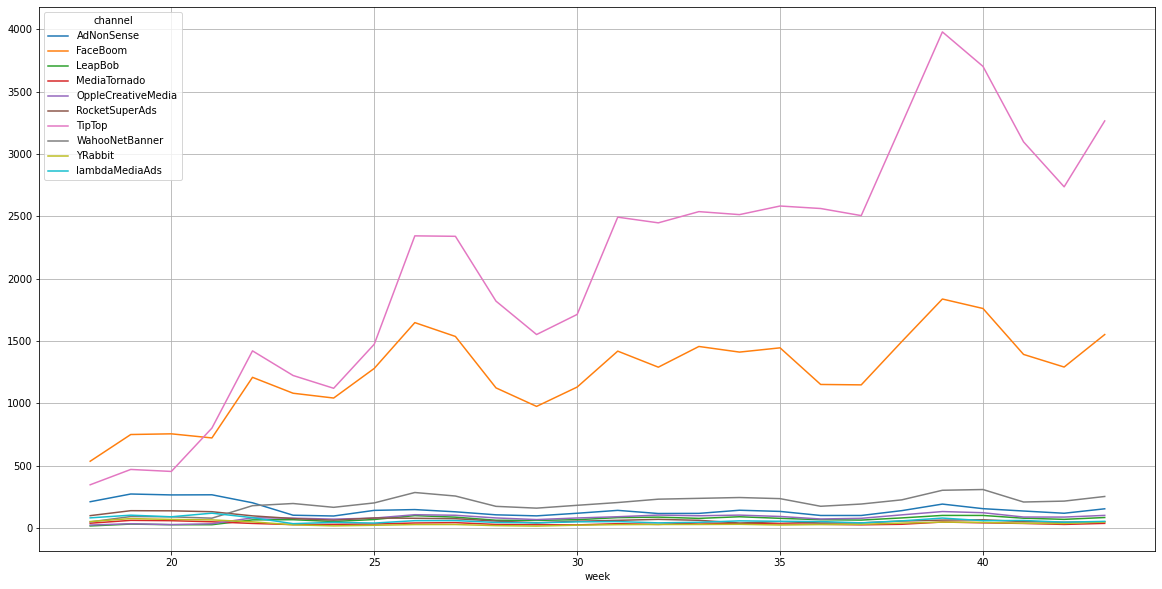

In [36]:
# Визуализируем динамику вложений на рекламу по неделям
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(20,10))

Увеличивающаяся динамика наблюдается у каналов TipTop и FaceBoom, у остальных затраты почти не изменяются.

<AxesSubplot:xlabel='week'>

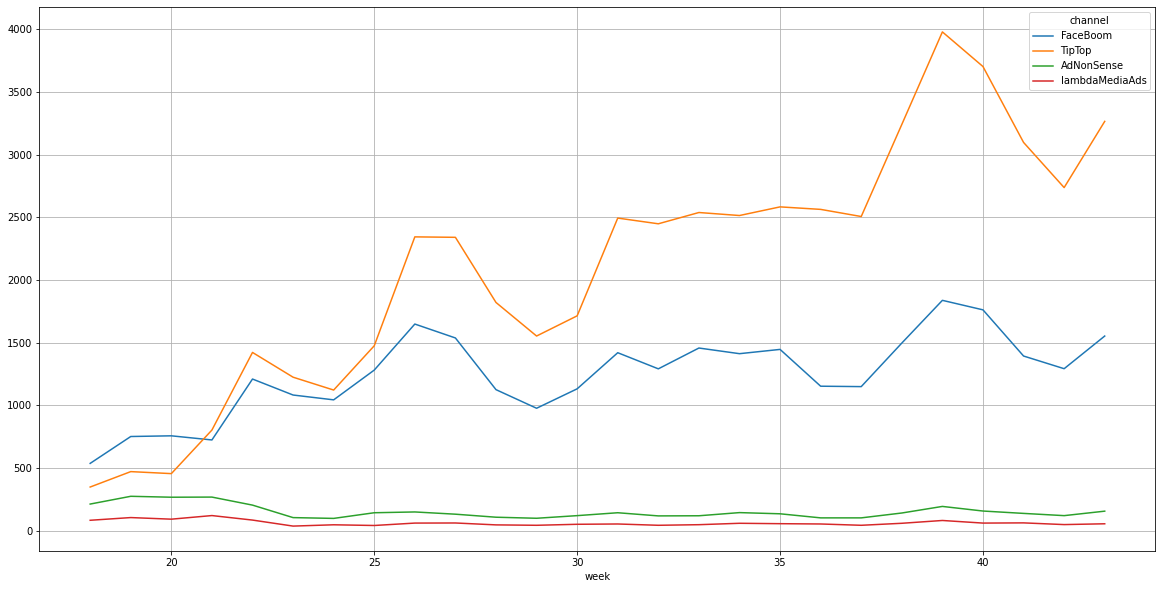

In [37]:
# Посмотрим отдельно на каналы, у которых процент платящих больше остальных
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot( y = ['FaceBoom', 'TipTop', 'AdNonSense', 'lambdaMediaAds'], grid=True, figsize=(20,10))

В канал Tip Top вкладываются больше всего, хотя по доле платящих пользователей он находится на четвертом месте. В канал FaceBoom также вклады увеличиваются, это канал приносит больше всего платящих пользователей.

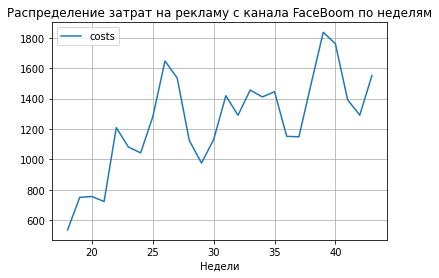

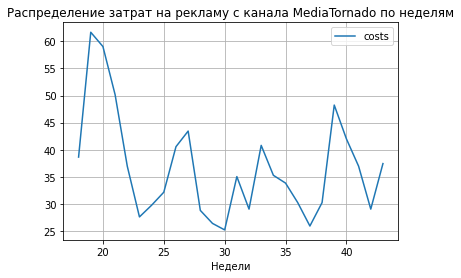

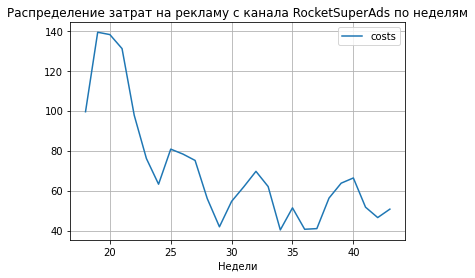

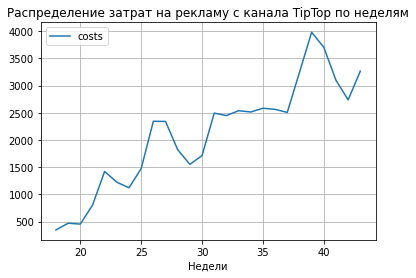

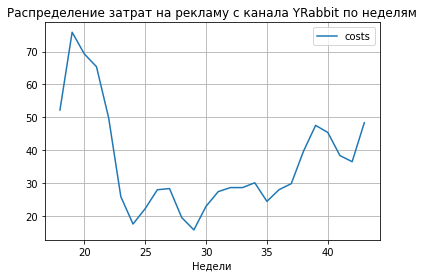

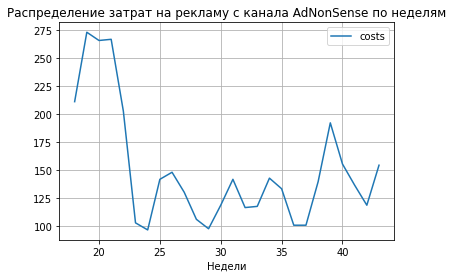

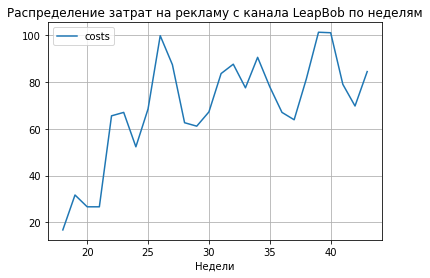

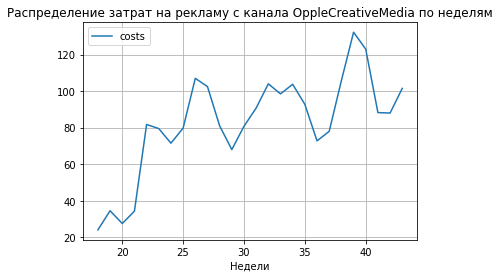

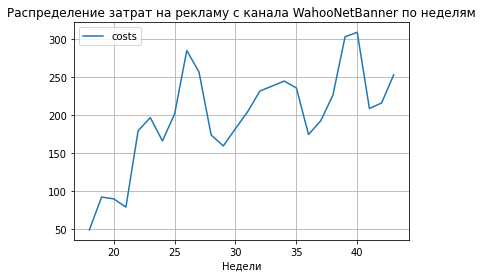

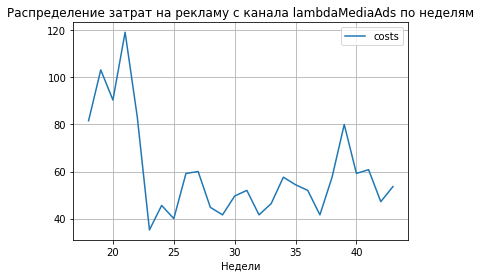

In [38]:
for i in costs['channel'].unique():
    costs[costs['channel'] == i].groupby('week').agg({'costs':'sum'}).plot(grid=True)
    plt.xlabel('Недели')
    plt.title(f'Распределение затрат на рекламу с канала {i} по неделям')

<AxesSubplot:xlabel='month'>

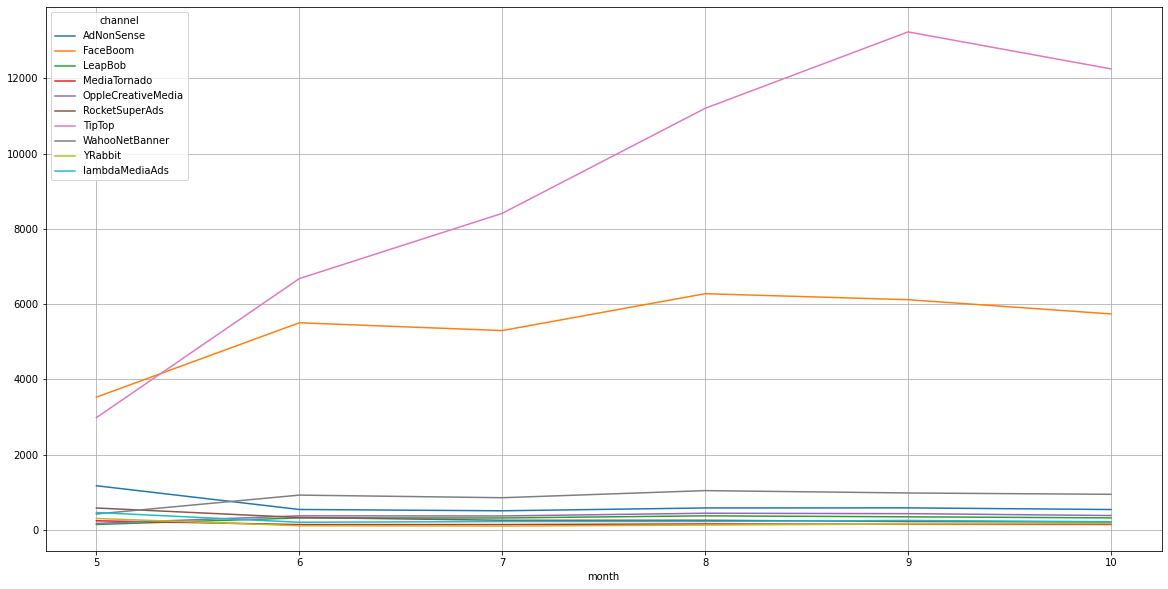

In [39]:
# Визуализируем динамику вложений на рекламу по месяцам
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(20,10))

<AxesSubplot:xlabel='month'>

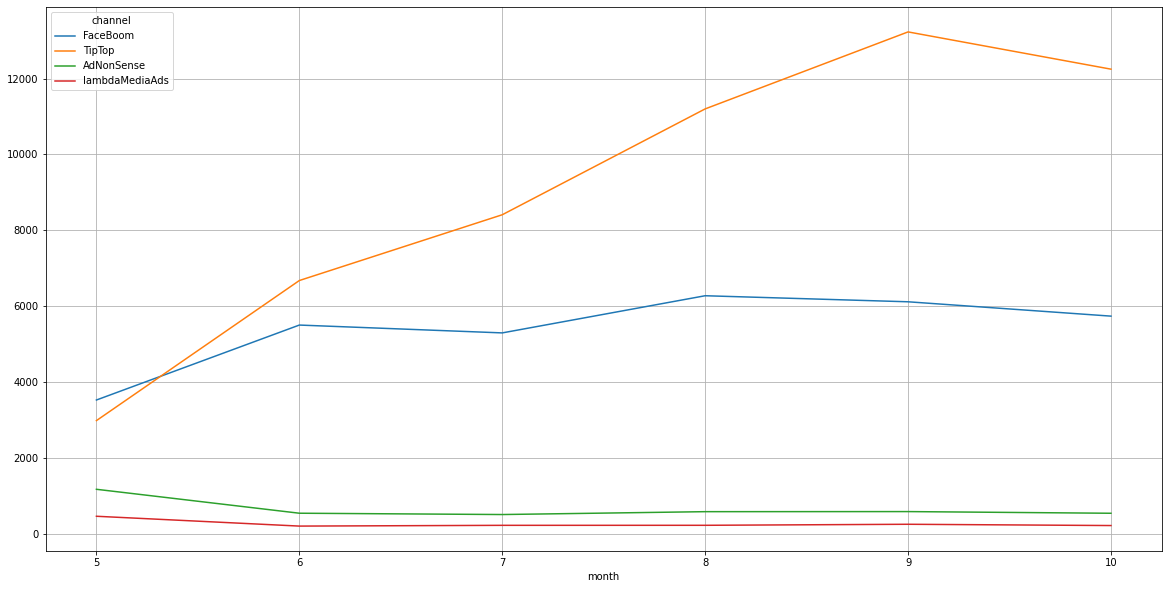

In [40]:
# Посмотрим отдельно на каналы, у которых процент платящих больше остальных
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot( y = ['FaceBoom', 'TipTop', 'AdNonSense', 'lambdaMediaAds'], grid=True, figsize=(20,10))

При распределени по месяцам картина не меняется.

In [41]:
# Установим горизонт и дату исследования
observation_date = datetime(2019, 11, 1).date()
horizon = 14

In [42]:
# Узнаем САС по каналам 
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon,
    dimensions=['channel'],
    ignore_horizon=False)
roi_grouped['cac'].sort_values(ascending=False)

channel
TipTop                2.757774
FaceBoom              1.113419
AdNonSense            1.008023
lambdaMediaAds        0.727237
WahooNetBanner        0.601856
RocketSuperAds        0.417431
OppleCreativeMedia    0.249908
MediaTornado          0.219035
YRabbit               0.217087
LeapBob               0.210000
Name: cac, dtype: float64

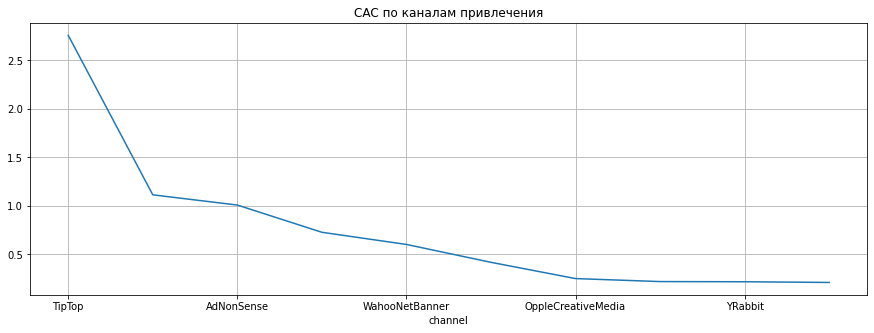

In [43]:
roi_grouped['cac'].sort_values(ascending=False).plot(grid=True, figsize=(15,5))
plt.title('CAC по каналам привлечения')
plt.show()

Привлечение одного пользователя с канала TipTop обходится компании дороже всего, FaceBoom и AdNonSense также недешевое, у остальных САС меньше 1.

Можем сказать, что компания увеличивает затраты на рекламу на каналах TipTop и FaceBoom. Стоимость привлечения одного пользователя самая дорогая у канала TipTop, хотя по доле платящих он на четвертом месте. Второй по САС является канал FaceBoom, что оправдано ведь он является первым по долям платящих пользователей.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

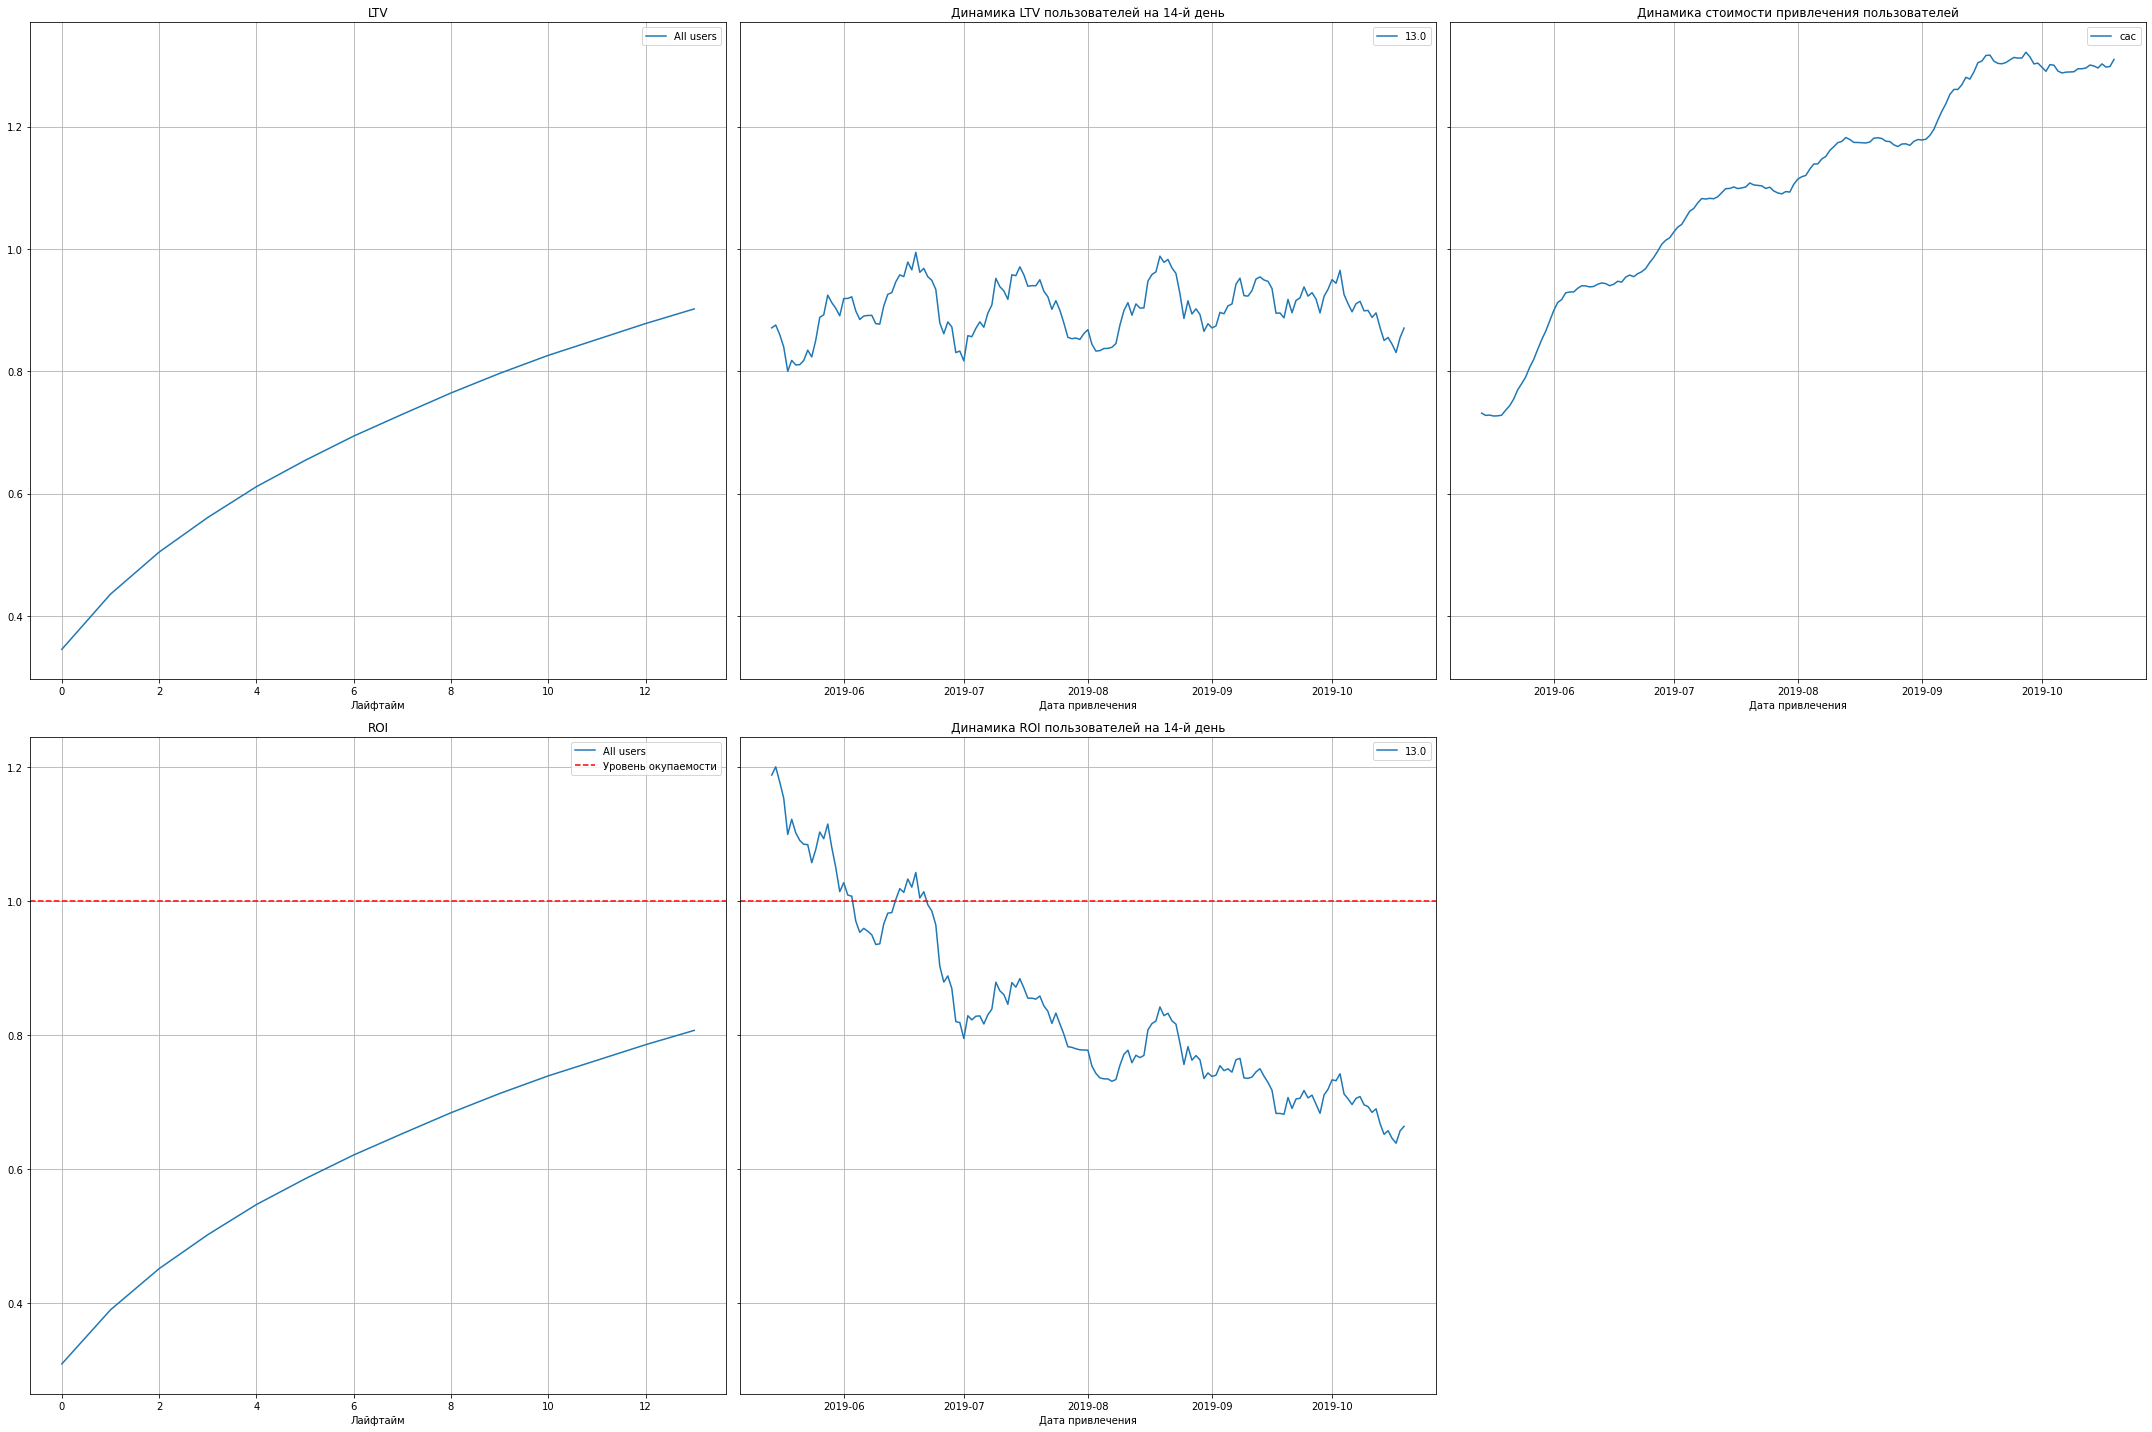

In [44]:
# Построим графики LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon,
    dimensions=[],
    ignore_horizon=False)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon) 

Можем сказать, что в целом реклама не окупается. 
- ROI в конце второй недели чуть больше 80%
- Если судить по графику САС это может быть из-за увеличения затрат на рекламу
- LTV стабилен, получается дело не в качестве пользователей

#### LTV и ROI по каналам ####

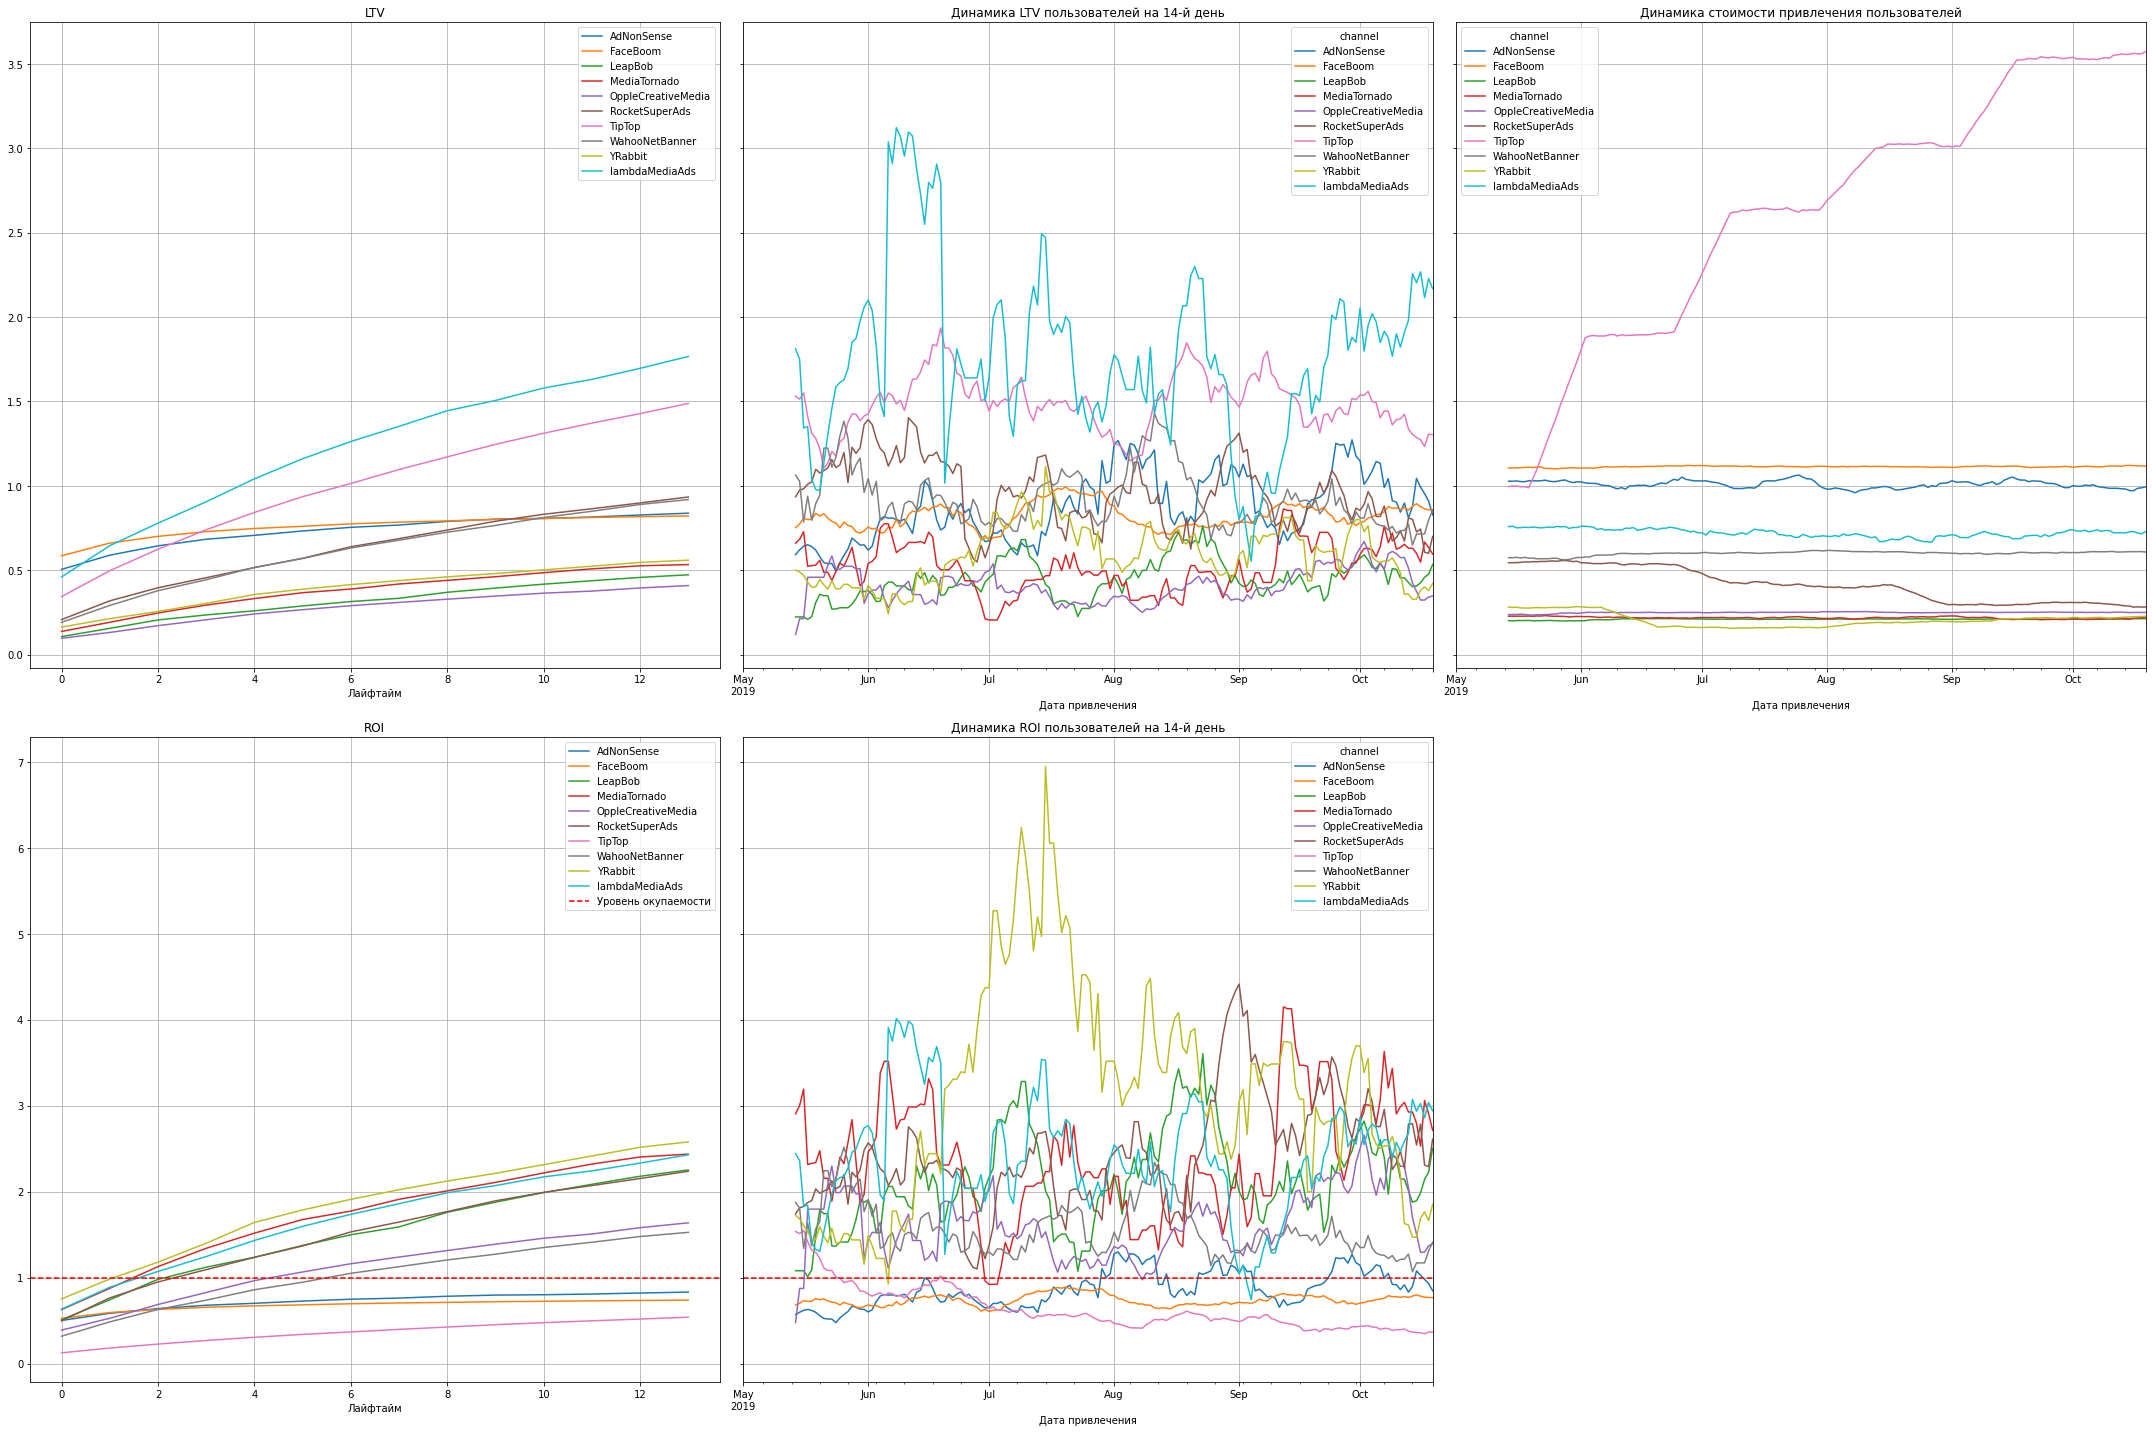

In [45]:
# Посмотри графики LTV и ROI по каналам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon,
    dimensions=['channel'],
    ignore_horizon=False)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon) 

Судя по графикам реклама не окупается только у трех каналов:TipTop, AdNonSense и FaceBoom, в эти каналы вкладываются больше всего, осбенно в TipTop. LTV lambdaMediaAds и TipTop увеличивается лучше всех. У YRabbit был скачок LTV, возможно, была рекламная акция или сработал другой фактор.

#### LTV и ROI по устройствам ####

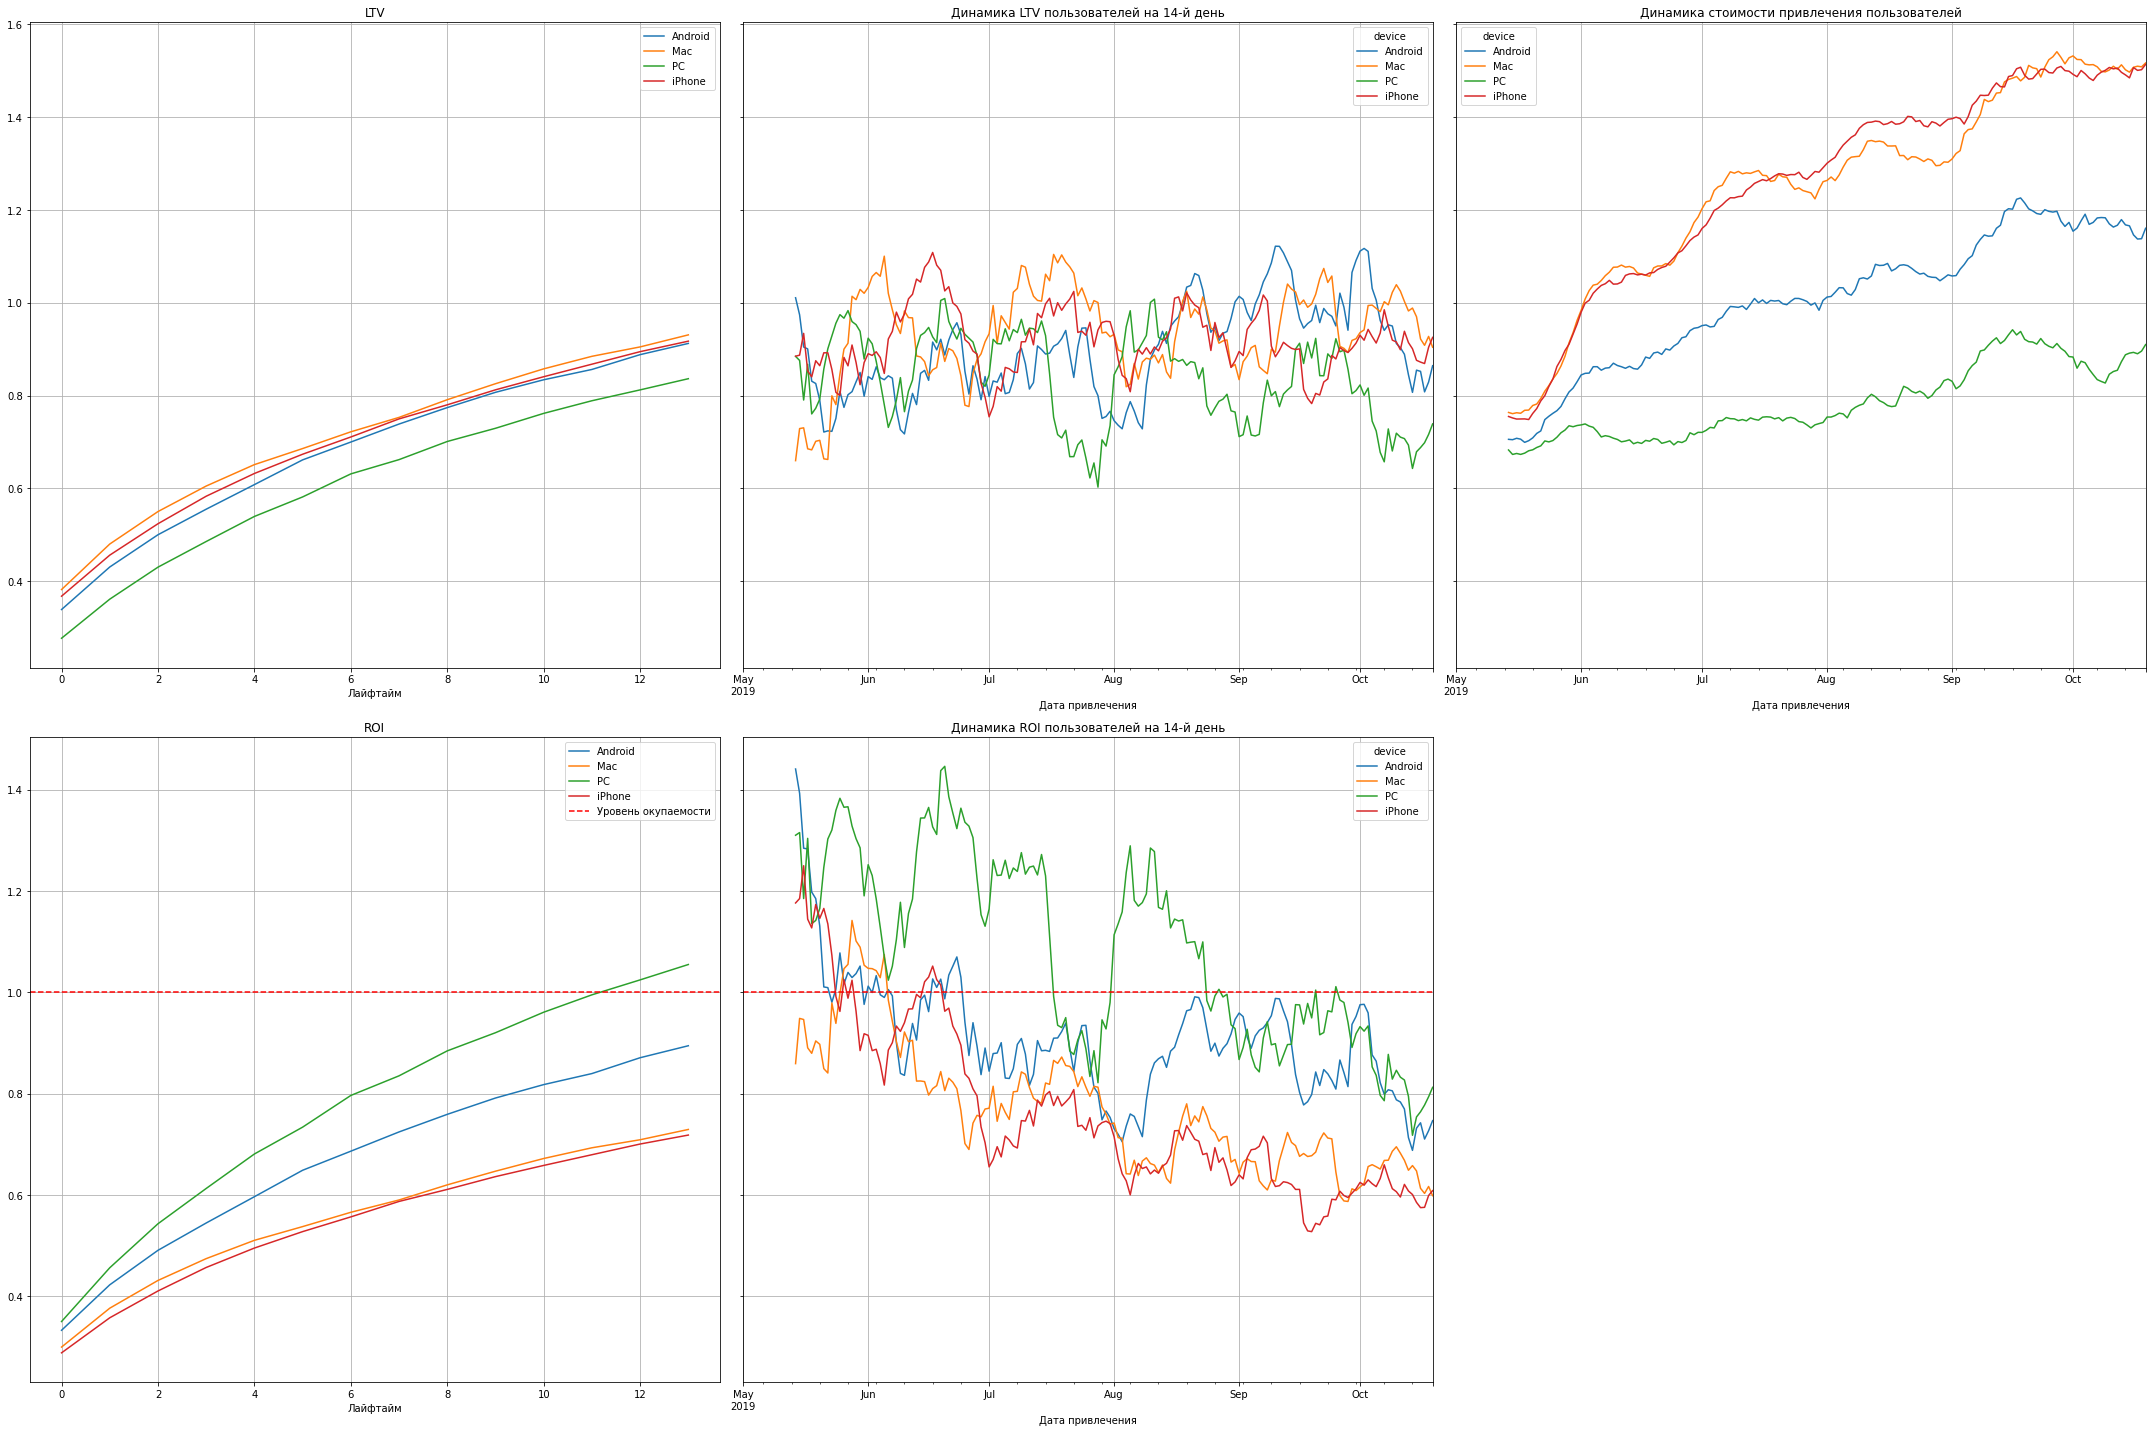

In [46]:
# Посмотри графики LTV и ROI по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon,
    dimensions=['device'],
    ignore_horizon=False)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon) 

Устройства на платформе ios окупаются хуже всего, хотя доля платящих у них выше всех, у них выражено увеличивается САС, возможно, именно поэтому окупаемость ниже. Лишь пользователи РС окупаются. LTV у всех достаточно стабильное, дело не в качестве пользователей.<br>
Причина не в устройствах.


#### LTV и ROI по странам ####

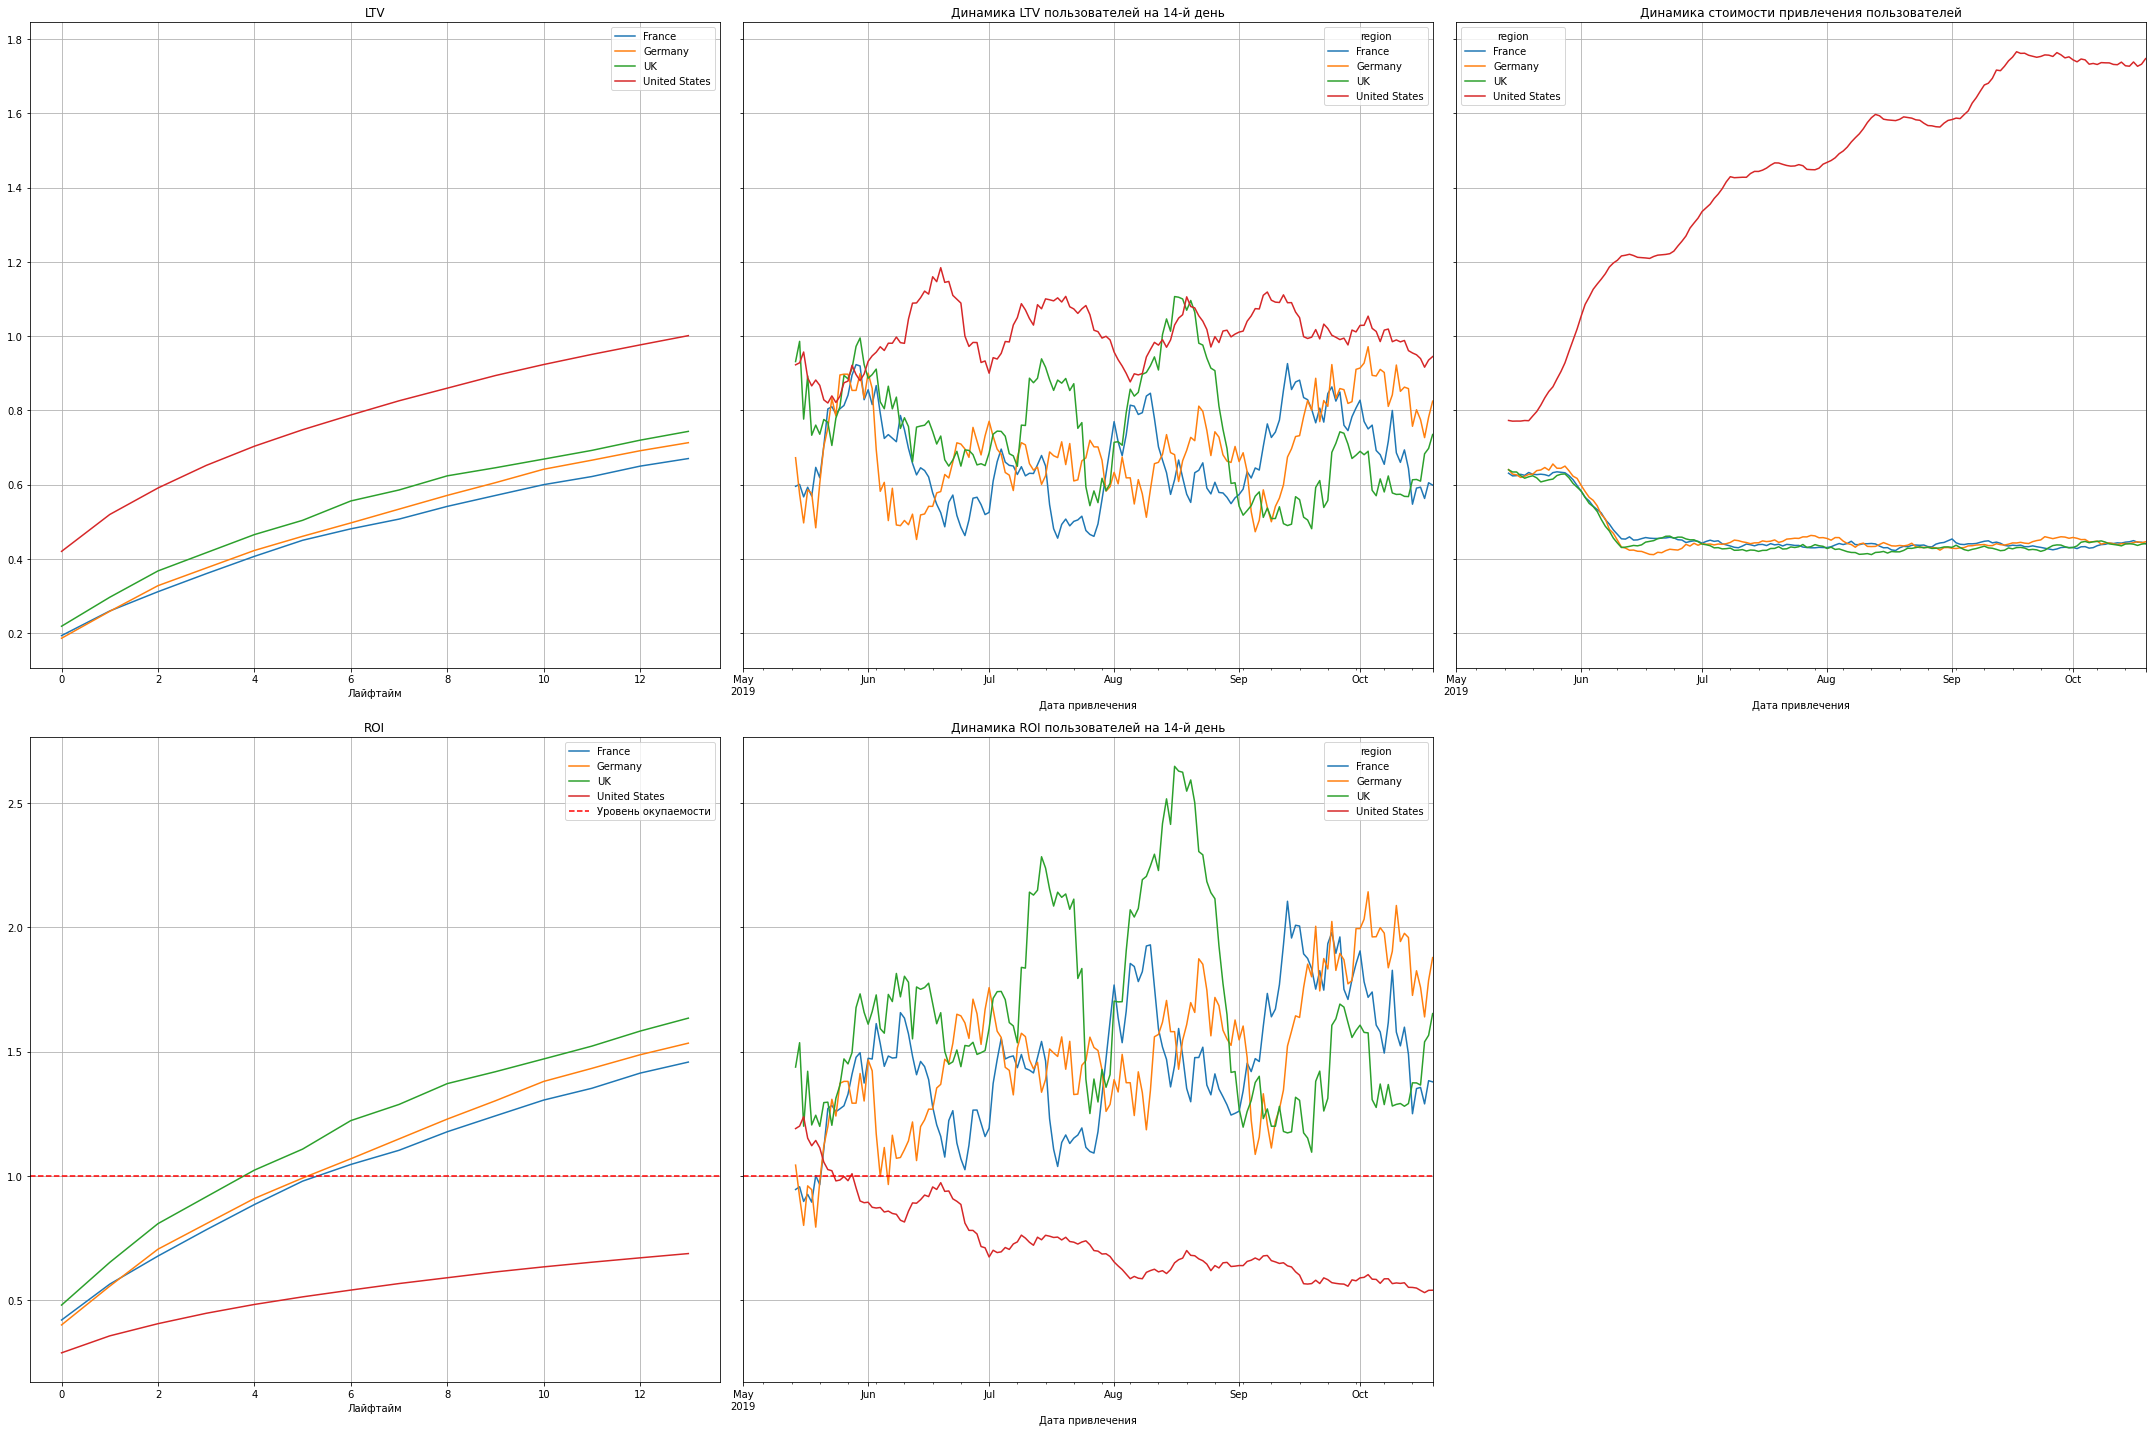

In [47]:
# Посмотри графики LTV и ROI по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon,
    dimensions=['region'],
    ignore_horizon=False)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon) 

Лишь пользователи из США не окупаются, но у них и САС сильно выше остальных, это может объяснить такой низкий ROI. Хотя по графикам динамики ROI начал уменьшаться одновремено с увеличением САС. LTV сезонный, но стабильный.<br> США явно выделяется, может дело в стране.

#### Конверсия по каналам ####

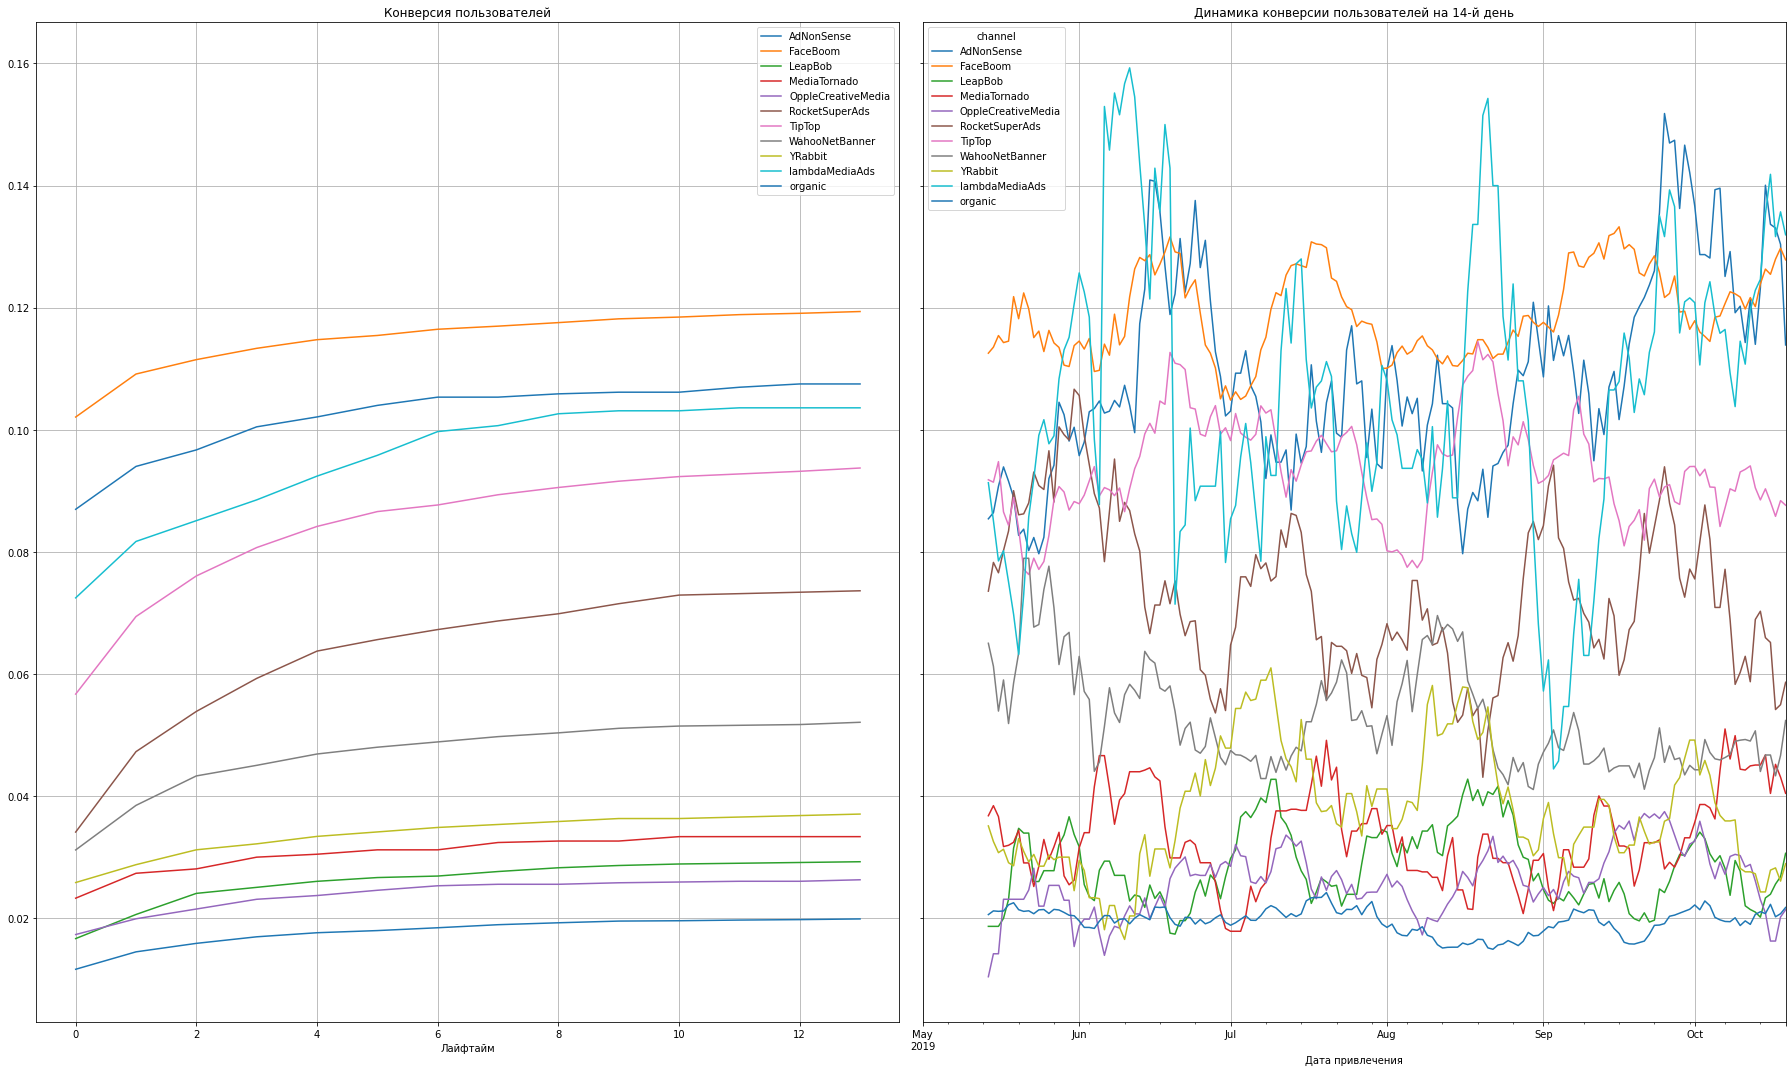

In [48]:
# Расчитаем конверсию по каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon) 

#### Удержание по каналам ####

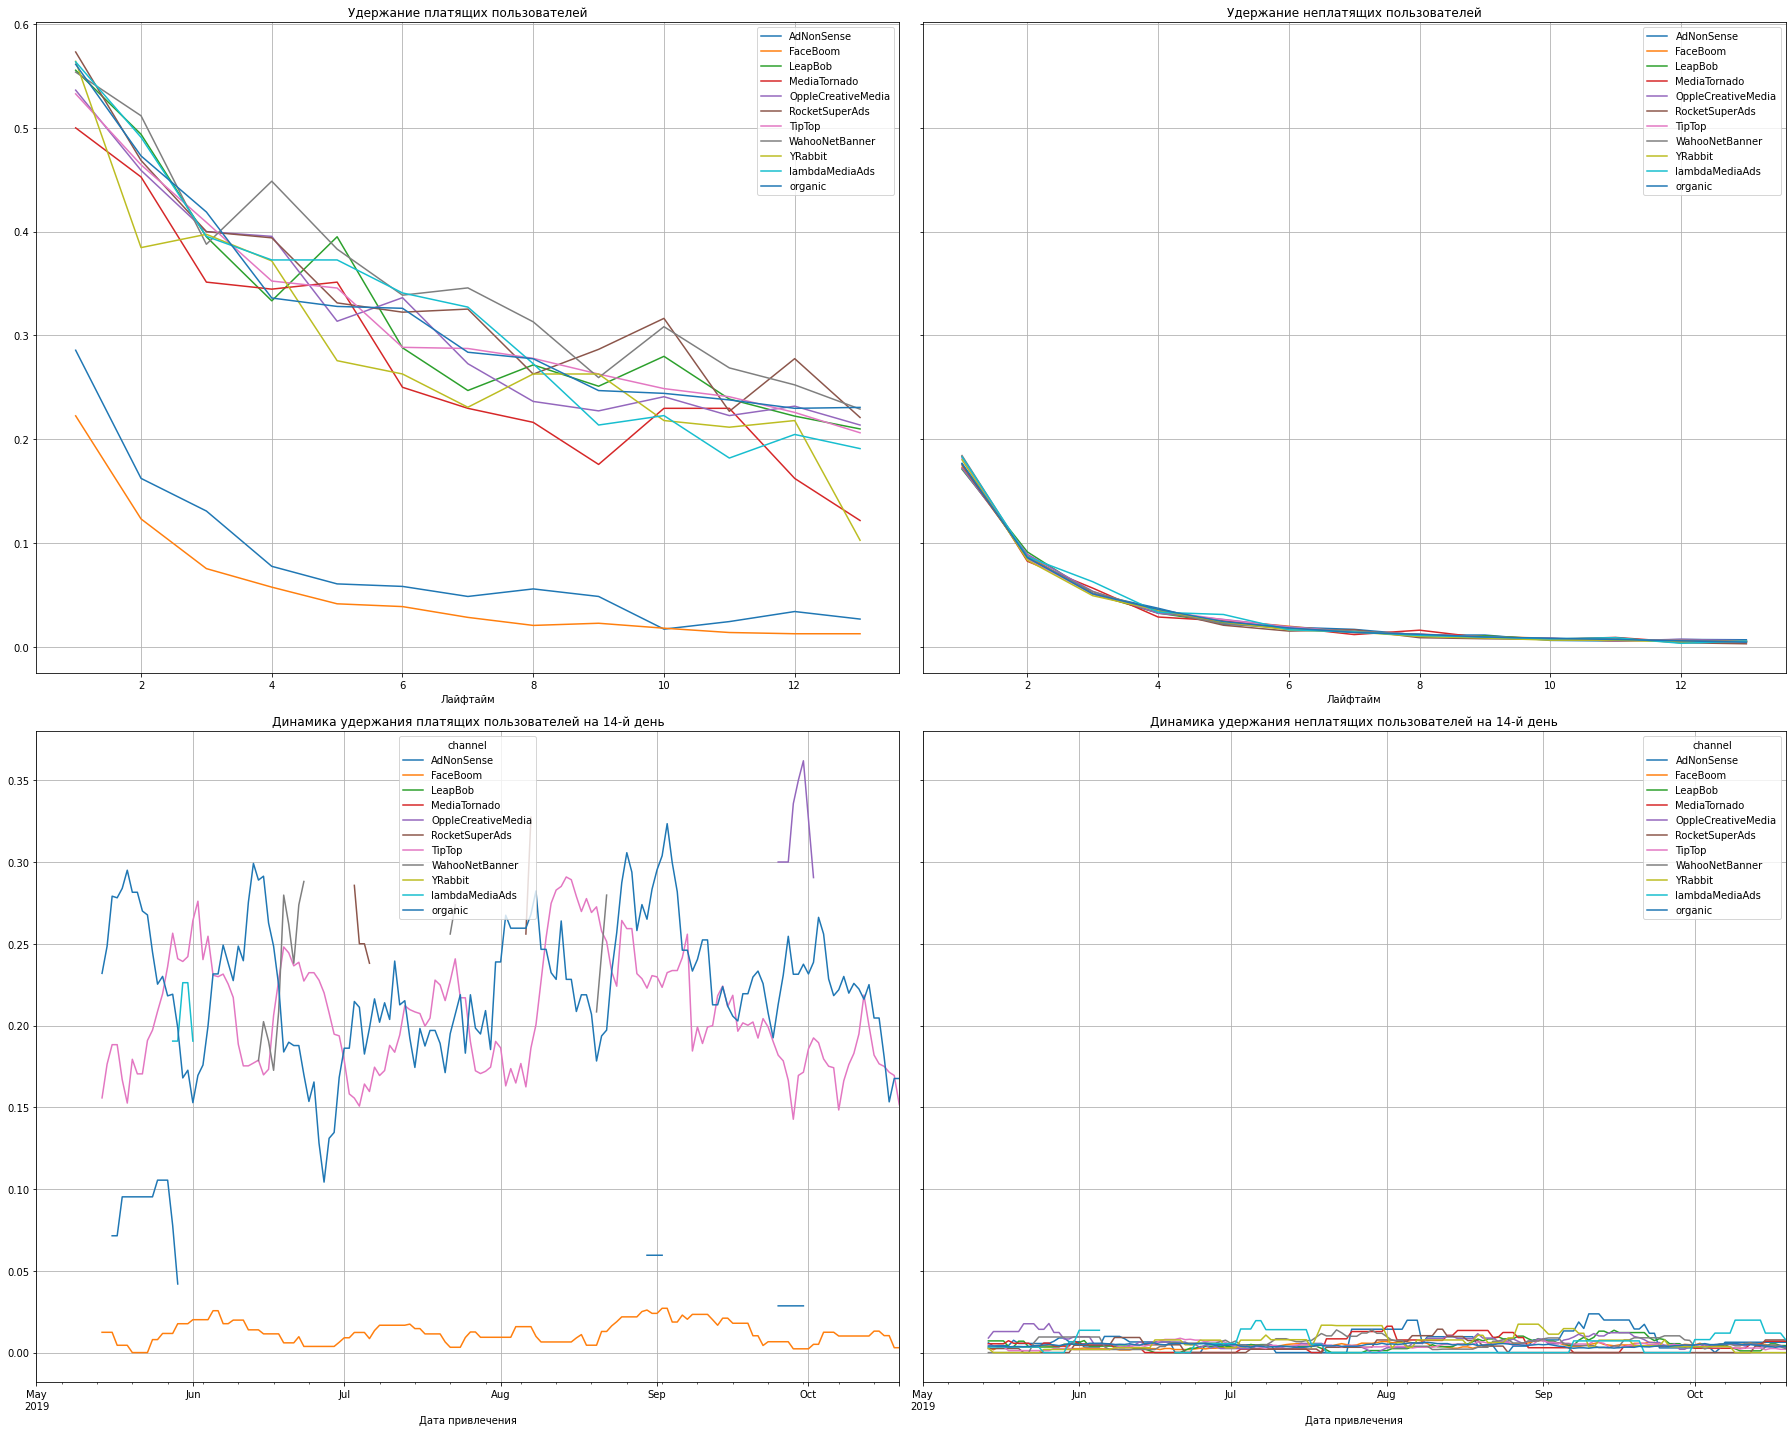

In [49]:
# Расчитаем удержание по каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon) 

Конверсия у неокупаемых каналов достаточно высокая, а вот удержание меньше остальных примерно на 20%, кроме канала TipTop. Удержание платящик колеблется, тк платящие возвращаются за услугой.

#### Конверсия по странам ####

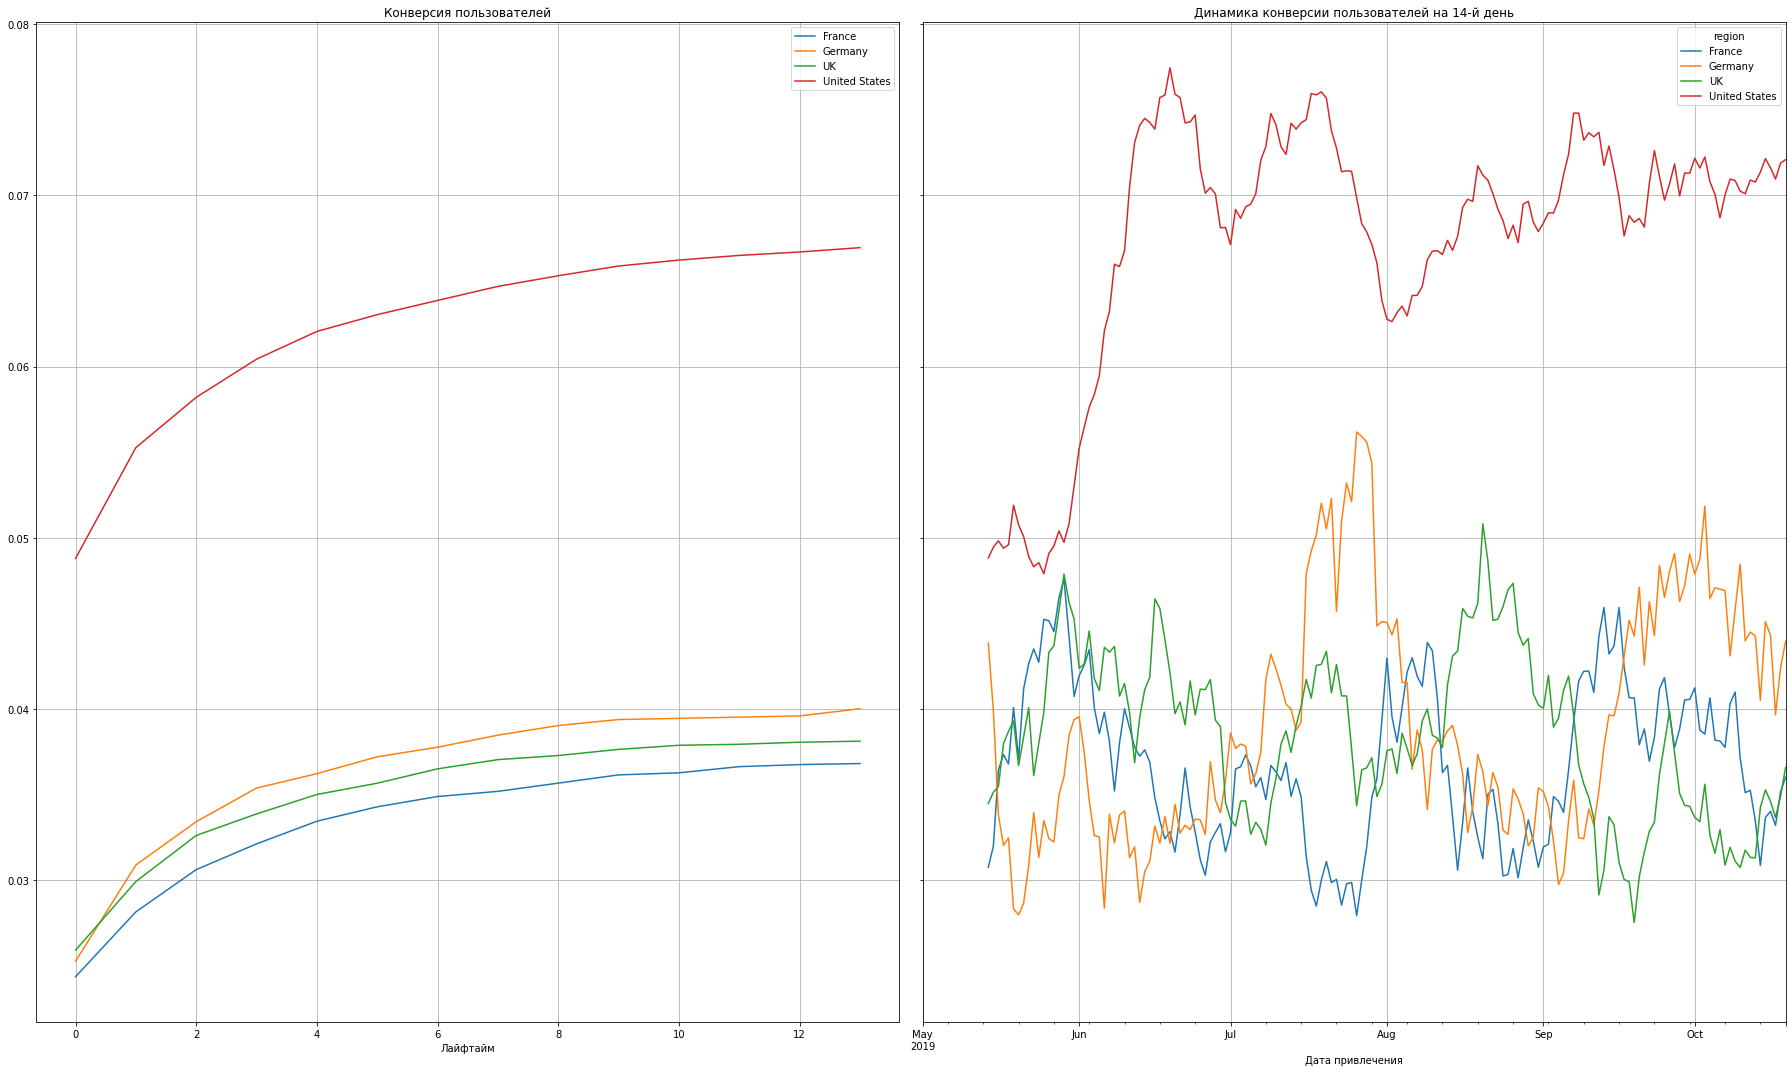

In [50]:
# Посчитаем конверсию по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon, dimensions=['region'])

plot_conversion(conversion_grouped, conversion_history, horizon) 

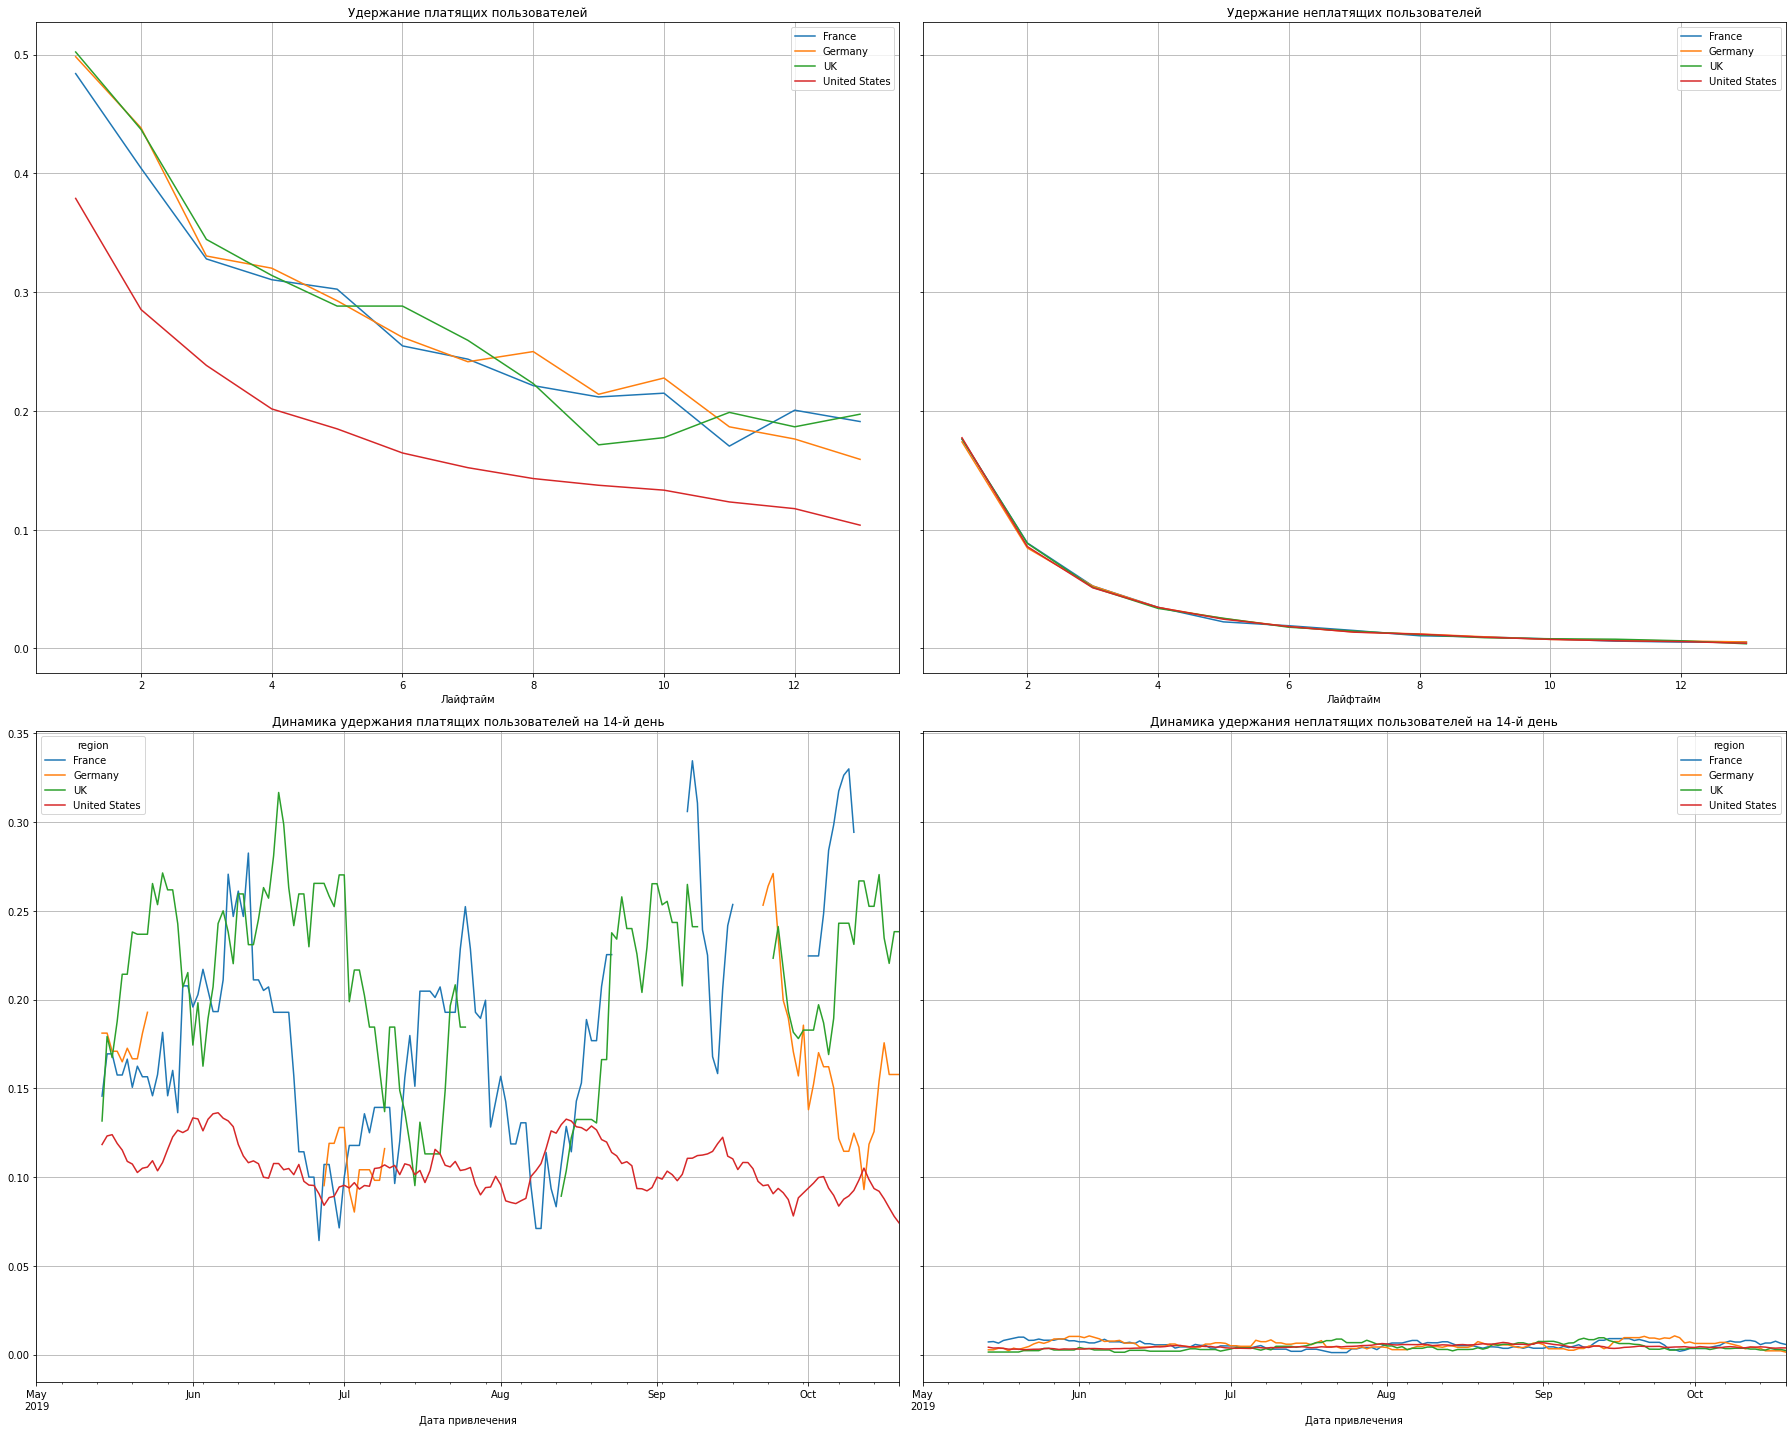

In [51]:
# Посчитаем удержание по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon, dimensions=['region'])

plot_retention(retention_grouped, retention_history, horizon) 

In [64]:
profiles_usa = profiles.query('region == "United States"')

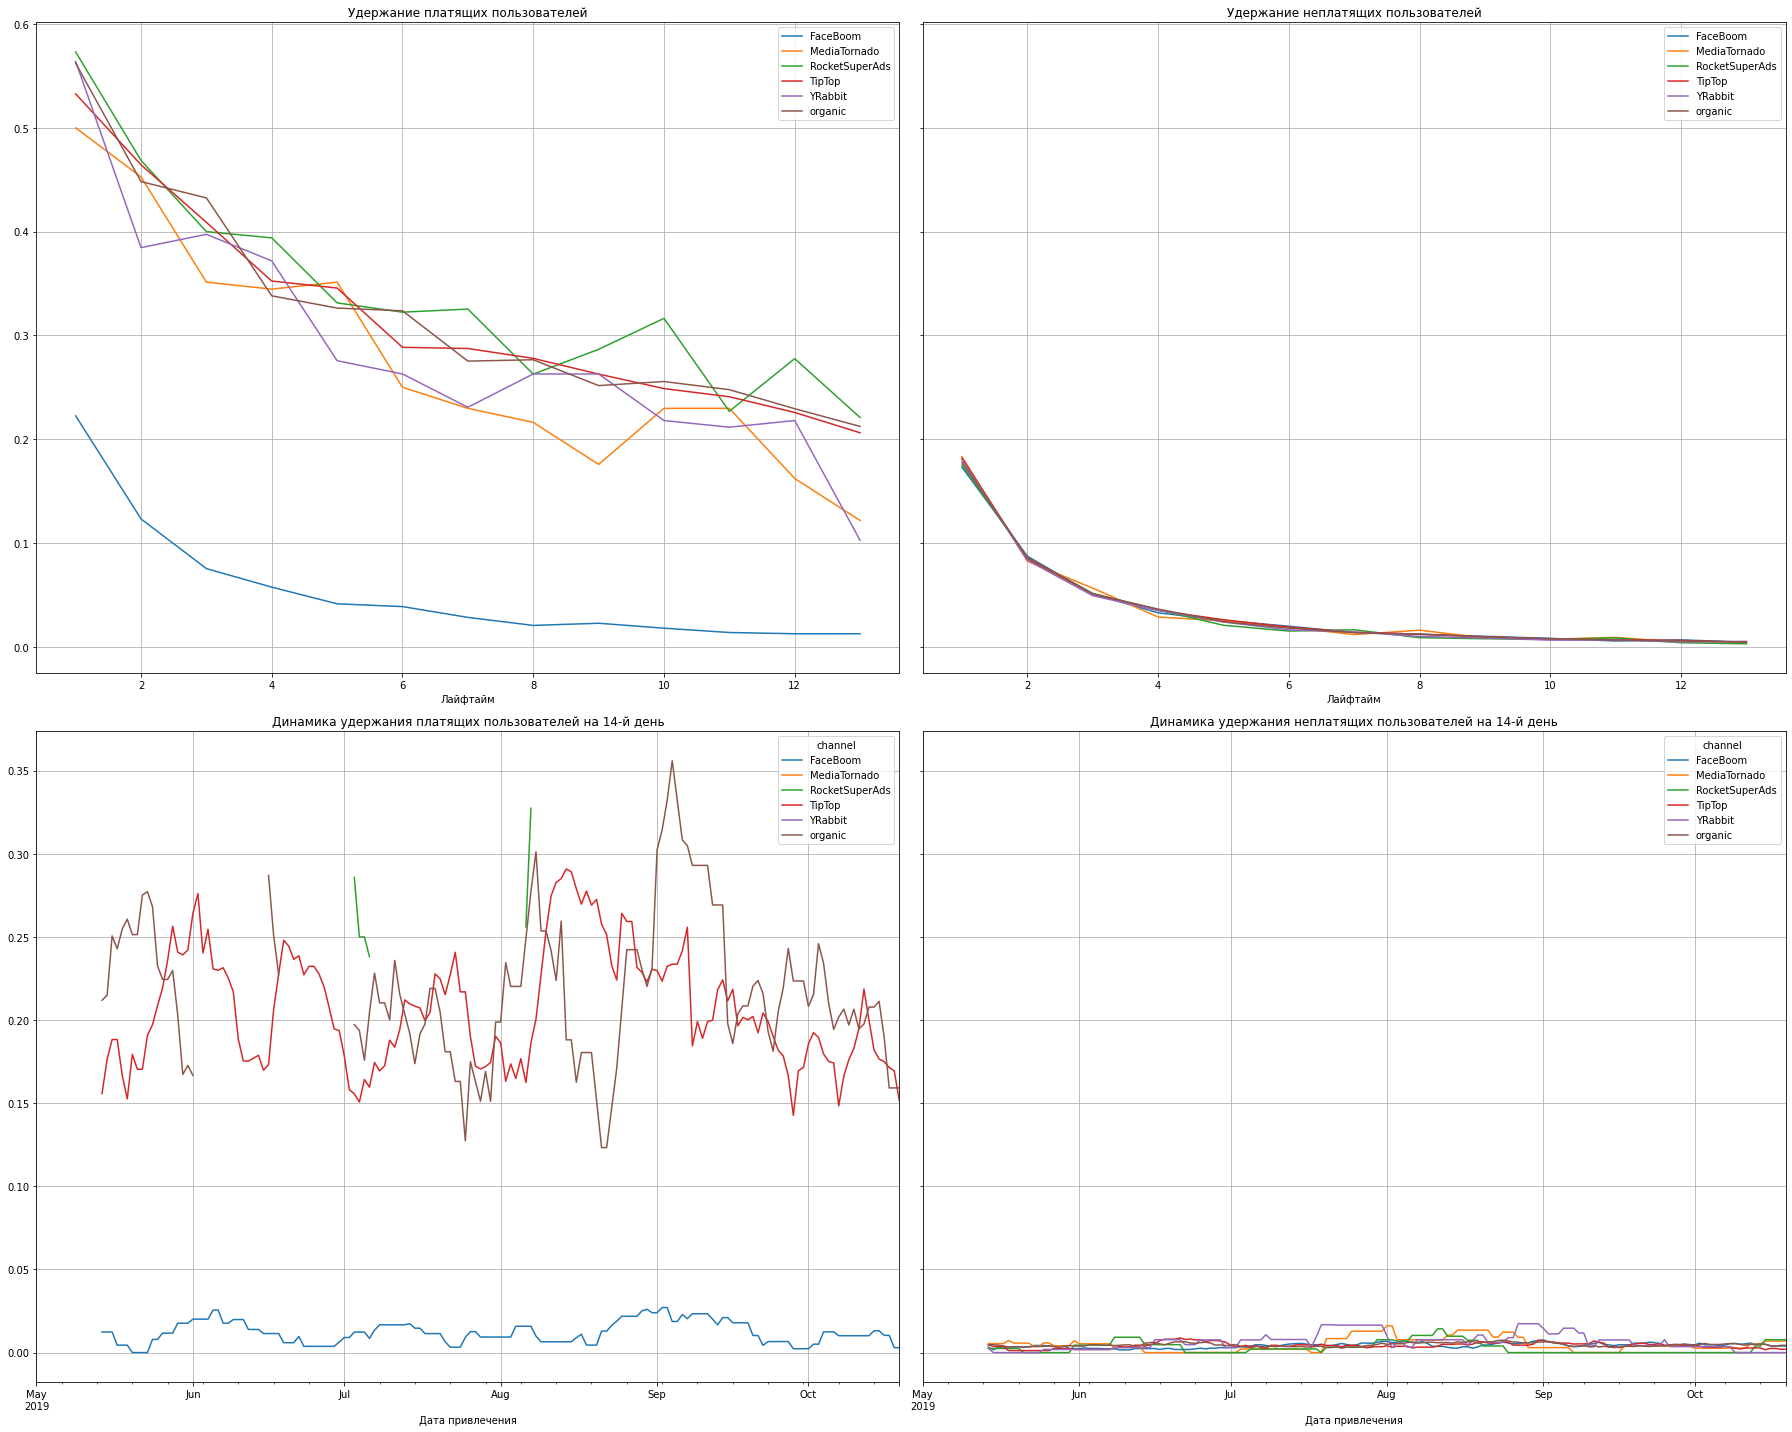

In [65]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon)

Явное отличие в удержании наблюдается у канала Faceboom, возможно на этом сайте есть какие-то технические неполадки.

### Вывод

Судя по данным больше всего пользователей используют iPhone, меньше всего Mac. Хотя доля платящих максимальная у Mac, наименьшая у пользователей РС.<br>
- Рекомендации: Увеличить количество пользователей Мас (персональные рекламы), увеличить количество платящих пользователей РС (бонусы, промокоды, скидки)<br>

Каналы, привлекающие больше пользователей, это TipTop и FaceBoom. Доля платящих пользователей равная больше 10% приходит на такие каналы как FaceBoom, AdNonSense и lambdaMediaAds.<br>
- Рекомендации: продолжить рекламную стратегию на FaceBoom. Увеличить кол-во платящих пользователей с канала TipTop,тк оттуда приходит их больше всего.Увеличить кол-во пользователей с каналов AdNonSense и lambdaMediaAds, там большая доля платящих.<br>

В США больше всего привлеченных пользователей, там же доля платящих наибольшая почти 7%, в остальных странах процент меньше 5.<br>
- Рекомендации: увеличить долю платящих в США, там огромная аудитория. В остальных странах работать над привлечением. В США наблюдается низкое удержание по каналу Faceboom, стоит проверить на его функционирование.<br>

При исследовании окупаемости рекламы, выявлено, что в целом она не окупается.<br>
Нестабильные метрики наблюдаются в США на каналах AdNonSense и FaceBoom.<br>
*Возможная причина: В США проблемы с сайтом FaceBoom.*